In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('TB_nation.xlsx',index_col='Date')
datasets_pred = datasets[datasets.index>='2014-01-1']
datasets = datasets[datasets.index<'2014-01-01']
datasets.shape

(120, 7)

In [4]:
datasets['log_natural'] = datasets['Incidence_rate'].apply(lambda x: np.log10(x))

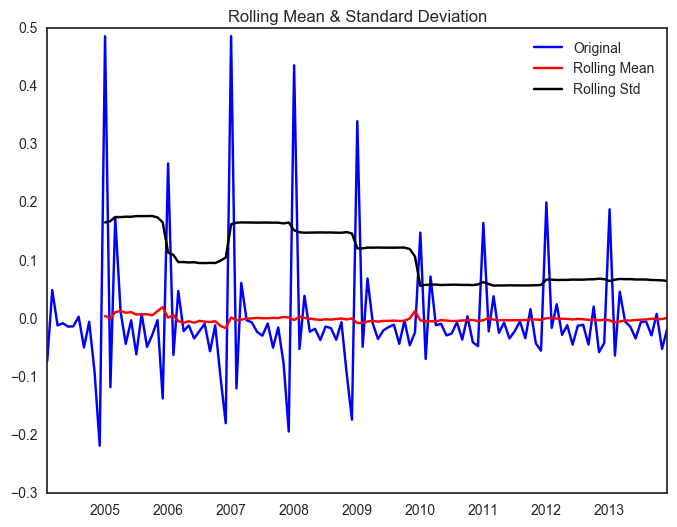

Results of Dickey-Fuller Test:
Test Statistic                  -4.213252
p-value                          0.000626
#Lags Used                      11.000000
Number of Observations Used    107.000000
Critical Value (5%)             -2.888955
Critical Value (1%)             -3.492996
Critical Value (10%)            -2.581393
dtype: float64


In [5]:
datasets['first_diff'] = datasets.log_natural - datasets.log_natural.shift(1)
test_stationarity(datasets.first_diff.dropna(inplace=False))

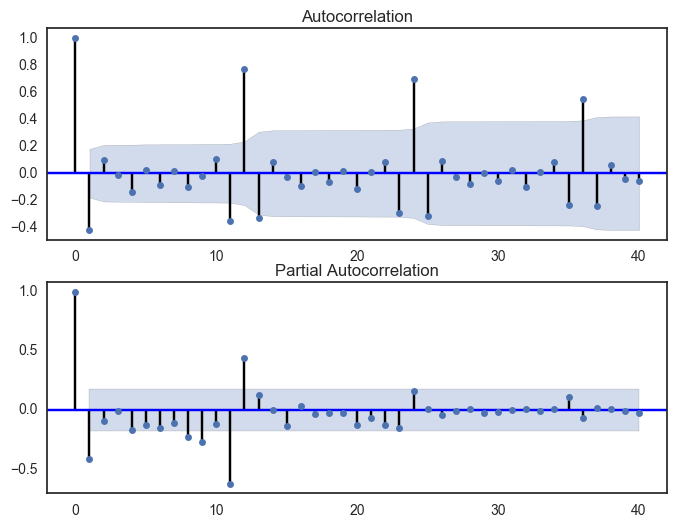

In [6]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.first_diff.iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.first_diff.iloc[1:], lags=40, ax=ax2)
# fig.savefig('Autocorrection.png',dpi=600)

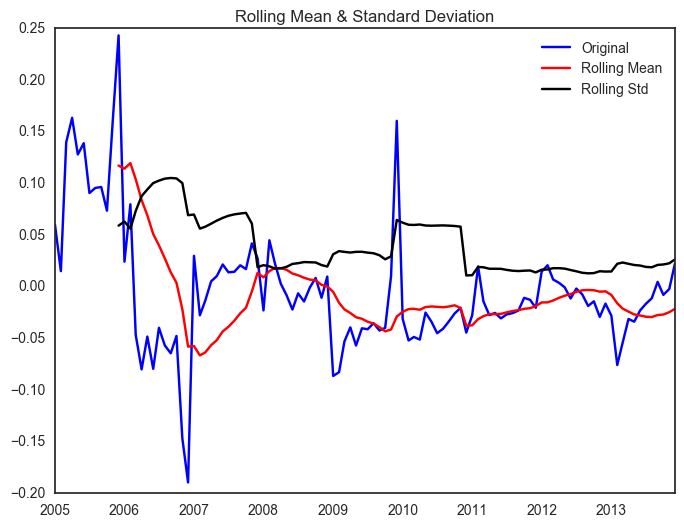

Results of Dickey-Fuller Test:
Test Statistic                  -4.684223
p-value                          0.000090
#Lags Used                       0.000000
Number of Observations Used    107.000000
Critical Value (5%)             -2.888955
Critical Value (1%)             -3.492996
Critical Value (10%)            -2.581393
dtype: float64


In [7]:
datasets['seasonal_difference'] = datasets.log_natural - datasets.log_natural.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False))

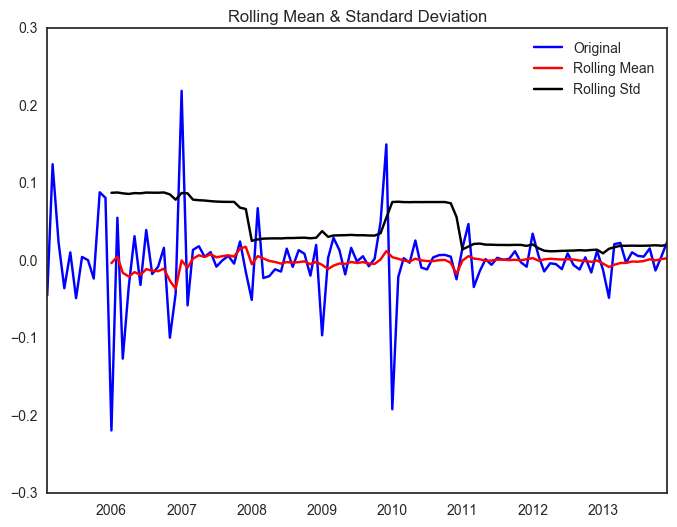

Results of Dickey-Fuller Test:
Test Statistic                -1.057487e+01
p-value                        7.148470e-19
#Lags Used                     1.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (5%)           -2.889485e+00
Critical Value (1%)           -3.494220e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


In [8]:
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

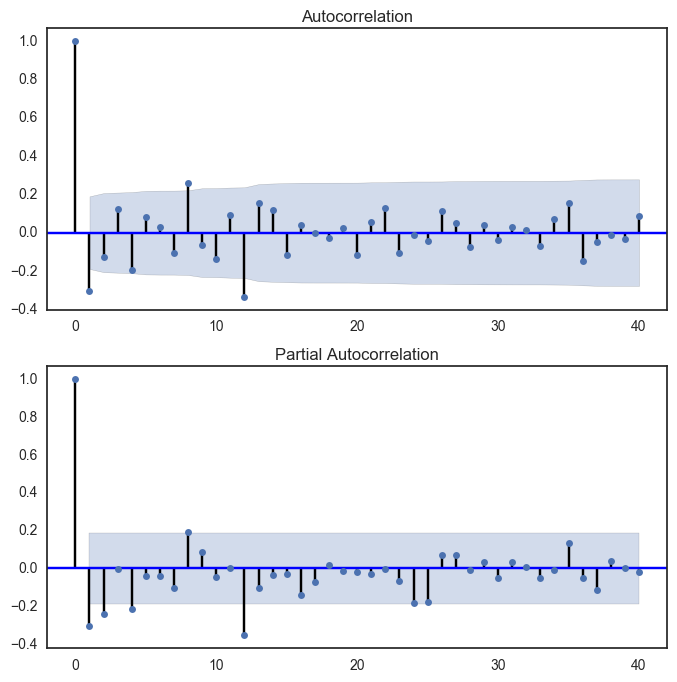

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)
# fig.savefig('Autocorrection.png',dpi=600)

In [10]:
mod = sm.tsa.SARIMAX(datasets.log_natural, trend='n', order=(0,1,2), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        log_natural   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 187.591
Date:                            Wed, 12 Oct 2016   AIC                           -367.182
Time:                                    00:37:04   BIC                           -356.032
Sample:                                01-01-2004   HQIC                          -362.654
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4493      0.057     -7.815      0.000      -0.562      -0.337
ma.L2         -0.1320      0.087   

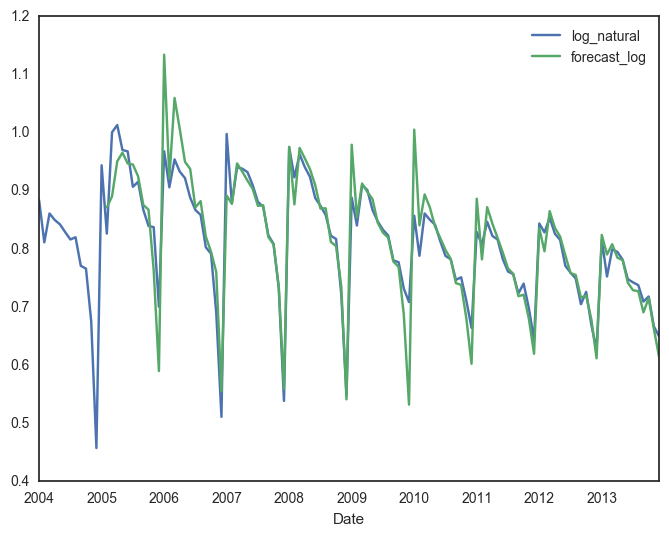

In [11]:
datasets['forecast_log'] = results.predict(start = 13, end= 131, dynamic= False)  
datasets[['log_natural', 'forecast_log']].plot(figsize=(8, 6))

In [12]:
dta = pd.concat([datasets, datasets_pred])[['Incidence_rate','log_natural','forecast_log','Year','Month']]
dta['forecast_log'] = results.predict(start=13,end=131,dynamic=False)
dta['forecast'] = dta['forecast_log'].apply(lambda x: np.exp(x))
dta.tail(25)

,Incidence_rate,log_natural,forecast_log,Year,Month,forecast
Date,,,,,,
2012-12-01,4.236613,0.627019,0.611653,2012,12,1.843477
2013-01-01,6.538876,0.815503,0.823896,2013,1,2.279364
2013-02-01,5.653969,0.752353,0.790232,2013,2,2.203908
2013-03-01,6.296343,0.799088,0.807924,2013,3,2.243247
2013-04-01,6.232829,0.794685,0.784737,2013,4,2.191830
2013-05-01,6.045021,0.781398,0.780641,2013,5,2.182872
2013-06-01,5.595773,0.747860,0.741651,2013,6,2.099400
2013-07-01,5.524578,0.742299,0.728721,2013,7,2.072428
2013-08-01,5.464757,0.737571,0.727143,2013,8,2.069161


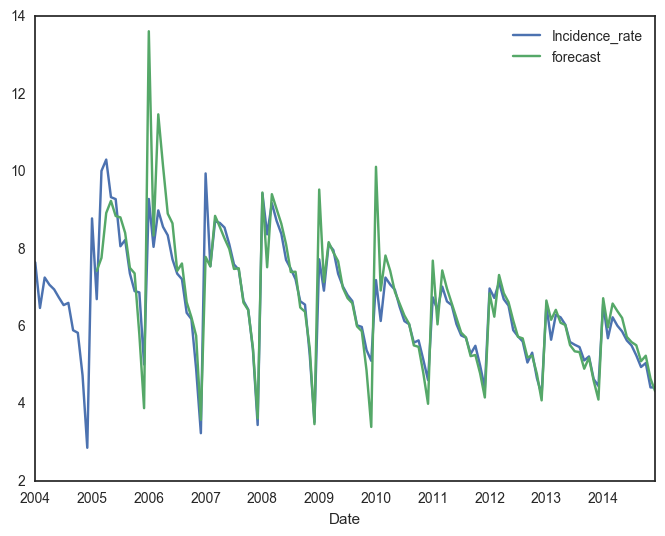

In [13]:
dta['forecast_log'] = results.predict(start=13,end=131,dynamic=False)
dta['forecast'] = dta['forecast_log'].apply(lambda x: 10**x)
dta[['Incidence_rate','forecast']].plot(figsize=(8, 6))

47.552522886523867

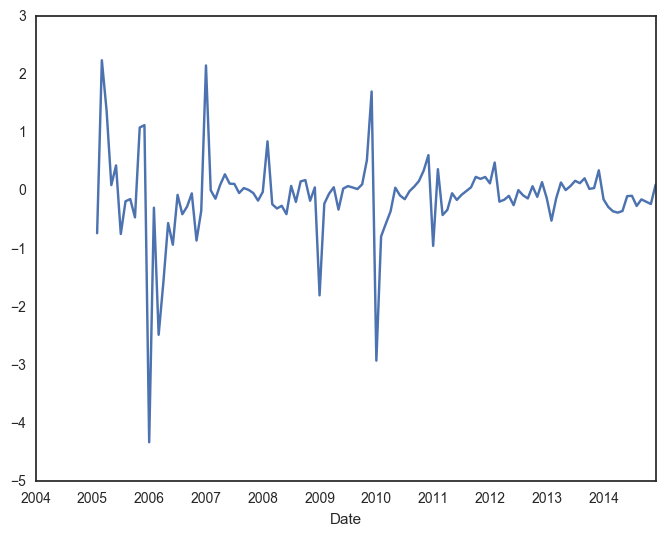

In [14]:
dta['error_ARIMA'] = dta['Incidence_rate']-dta['forecast']
dta['error_ARIMA'].plot(figsize=(8,6))
sum(abs(dta['error_ARIMA'].dropna()))

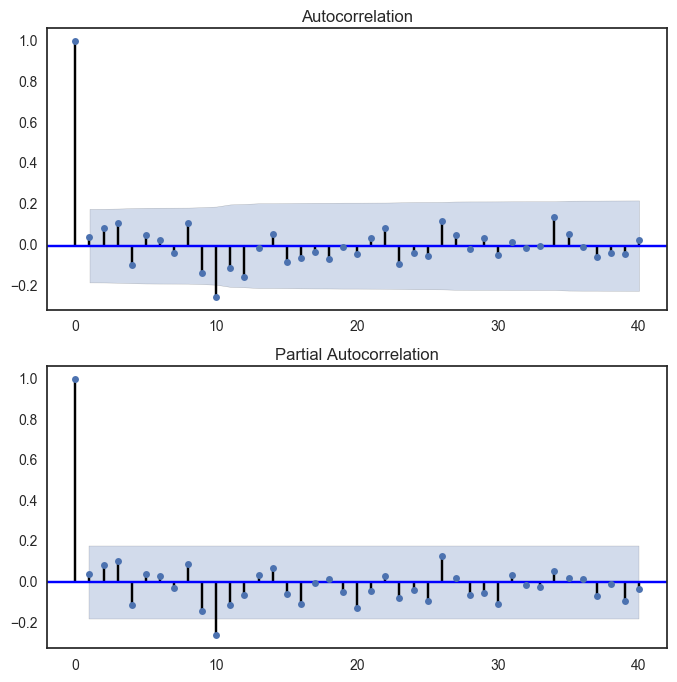

In [15]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.error_ARIMA.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.error_ARIMA.iloc[13:], lags=40, ax=ax2)
# fig.savefig('Autocorrection.png',dpi=600)